# Ring Background Estimation for GRB 190829A

## Introduction:

- In IACT data analysis, it is important to account for the large residual hadronic emission from the atmosphere or from different sources in the sky. 
- To make sure that the photons collected are from an exact position, an excess map, assumed to be a map of only gamma-ray events need to be produced, and requires a good estimate of the background. Here Background refer to other particle's or photons that comes from the target of interest (- protons, hadrons, CMBs, ...). 
- To optain a reliable background it is a bit complicated due to the lack of a solid template bkg model. 
- D. Berge et al 2007, introduced different background normalisation template that are necessary in classical cherenkov astronomy to perform a local renormalization of the existing templates, here we are interested in a ring kernel. 
- This assumes that most of the events are background and requires to have an exclusion mask to remove regions with bright signal from the estimation. 
- To read more about this method, see [here](https://arxiv.org/pdf/astro-ph/0610959.pdf).

## Objective

- We aim at Creating an excess Map (gamma-ray events) map of GRB 190829A as well as a significance map to determine how solid the signal is. We will also provide different maps for a detail exploration.

## Methods

- We will start by Computing the sky maps keeping each observation separately using the Analysis class (High level interfance) 
- We will estimate the background using the RingBackgroundMaker class provided in gammapy 
- We will compute the correlated excess and significance maps using the ExcessMapEstimator, taking into account the colleration radius (r = 0.05 deg) and in addition we will estimate background, Test statistics (TS) and upper limit maps at 3 sigma and a/symmetric errors at 1 sigma.

- The normalised background thus obtained can be used for general modelling and fitting.

## Implimentation

- We wi;l start by importing different clases of gammapy!!



*General imports*

In [1]:
%matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
from scipy.stats import norm
import scipy.optimize
import logging

log = logging.getLogger(__name__)

*Gammapy specific classes*

In [2]:
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.makers import RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import Map
from gammapy.datasets import MapDatasetOnOff


In [3]:
import warnings
warnings.filterwarnings('ignore')

### Set up and formating: Saving and plotting!

In [4]:
run_list = "night1"
bkgmodel_version = "v07c"

In [5]:
work_dir = "/Users/jean/Documents/PhD/gammapy/GRBs/190829A/v17/new_analysis/grb_analysis/"

def save(fig, figname, left = 0.15, bottom = 0.15, right = 0.95, top = 0.95):
    fig.subplots_adjust(left = left, bottom = bottom, top = top, right = right)
    format_fig = ['png','pdf', 'eps']
    for form in format_fig:
        fig.savefig(work_dir + "plots/plots_2D/{}/jupyter_notebooked/grb190829A_{}_{}.{}"
                    .format(run_list,run_list, figname, form))

In [6]:
W = 10
params = {'figure.figsize': (W, W/(4/3)),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
          'font.size' : 16,
         'text.usetex': True,
         'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'),
          'font.family': 'sans-serif',
          'legend.fontsize': 16,
          
          }

plt.rcParams.update(params)

## Run list

- Next we define the run list we wish to use (We will load data for these specific run list)

In [7]:
runs_night1 = [152900, 152901, 152902, 152903, 152904, 152905, 152906, 152907]
runs_night2 = [152960, 152961, 152962, 152963, 152965, 152966, 152967, 152968, 152969, 152970]
runs_night3 = [153040, 153041, 153042, 153043, 153044, 153047, 153048, 153049, 153050] # 153045 (too short)

if run_list == 'night1':
    runs = runs_night1
    
elif run_list == 'night2':
    runs = runs_night2
    
elif run_list == 'night3':
    runs = runs_night3
    
elif run_list == 'all':
    runs = runs_night1 + runs_night2 +runs_night3

## Define source position

In [19]:
source_pos = SkyCoord(44.544, -8.958, unit="deg")
star_ra = 44.106
star_dec = -8.9891
star_pos = SkyCoord(star_ra, star_dec, frame = 'icrs', unit = 'deg')


## Define and load the datasets

In [11]:
HESS_DATA = "$GAMMAPY_DATA/std_ImPACT_fullEnclosure" 


## Creating the config file

- Since we aim at high level interface we create the configuration file to be carriedin the analysis class. 
- There is a possibility to load this from the disc in case it was pre-defined.
- In this example, we will use runs from the first night (but the jupyter notebook are available differently) for HESS observations on the GRB , GRB 190829A

In [12]:
config = AnalysisConfig()
# Select observations - 2.5 degrees from the source position
config.observations.datastore = HESS_DATA
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": 2.5 * u.deg,
}

# First Night!

In [13]:
config.observations.obs_ids = runs

### Datasets Geometry

- We start by defining the Geometry to use for the data reduction.

In [14]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  # The WCS geometry - centered on GRB 190829A
config.datasets.geom.wcs.fov = {"width": "4 deg", "height": "4 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV radius to use for cutouts
config.datasets.geom.selection.offset_max = 2.5 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.13 TeV"
config.datasets.geom.axes.energy.max = "56 TeV"
config.datasets.geom.axes.energy.nbins = 42

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False
config.datasets.safe_mask.methods = ['offset-max']  
config.datasets.safe_mask.parameters = {'offset_max': 2.5 *u.deg}



In [15]:
#print(config)

### Getting the reduced dataset

- We now use the config file to do the initial data reduction which will then be used for a ring extraction.
- And we will then carry on with the Data extraction.

In [16]:
%%time
# create the config
analysis = Analysis(config)

# for this specific case,we do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

# First get the required observations, we have 8 runs.
analysis.get_observations()


# Data extraction
analysis.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 8
Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 152900
Processing observation 152901
Processing observation 152902
Processing observation 152903
Processing observation 152904
Processing observation 152905
Processing observation 152906
Processing observation 152907


CPU times: user 13.8 s, sys: 3.47 s, total: 17.3 s
Wall time: 17.4 s


## Extracting the ring background

- It is classically know that the ring background is extracted from real off events, we need to use the wstat statistics in this case.
- For this, we will use the MapDatasetOnOFF and the RingBackgroundMaker classes.

### Create exclusion mask

- But first, we need to create an exclusion mask on the known sources in the FoV. 
- In this case, we need to mask only GRB190829A, but this depends on the sources present in our field of view.

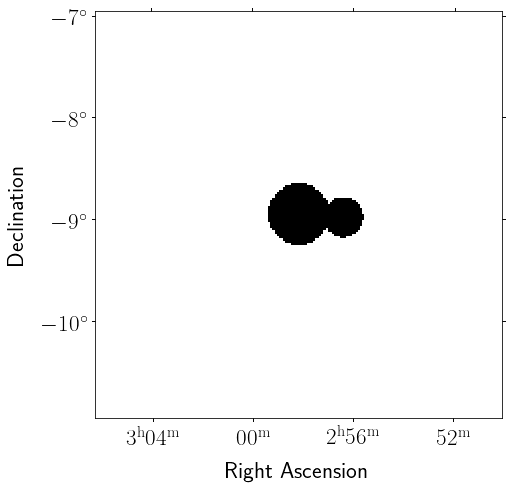

In [20]:
# get the geom that we use
fig = plt.figure()
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.get_axis_by_name("energy")
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
region_grb = CircleSkyRegion(center= source_pos, radius=0.3 * u.deg)
region_star = CircleSkyRegion(center= star_pos, radius=0.2 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([region_grb, region_star], inside=False)


exclusion_mask.sum_over_axes().plot();
#save(fig, '2D-exclusion-regions_high_level')

### Creating the ring 

- We use a ring with an inner radius of 0.5 deg and width of 0.3 deg just like in the gammapy tutorial (see tutorial [here](https://docs.gammapy.org/0.17/notebooks/ring_background.html?highlight=ringbackground)).


In [21]:
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

## Create a stacked dataset.

- Next, we extract the background for each dataset.
- And then stack the maps together to create a single stacked map to be used for further analysis, or can be save on the disc too!

In [22]:
%%time
stacked_on_off = MapDatasetOnOff.create(geom=geom_image)
for dataset in analysis.datasets:
    dataset_image = (
        dataset.to_image()
    )  # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_maker.run(dataset_image)
    stacked_on_off.stack(dataset_on_off)

CPU times: user 896 ms, sys: 336 ms, total: 1.23 s
Wall time: 1.23 s


- This stacked_on_off has on and off counts and acceptance maps which we will use in all further analysis. 
- The acceptance and acceptance_off maps are the system acceptance of gamma-ray like events in the on and off regions respectively.
- We can look at it below! ...

In [23]:
print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : UStuMrX_ 

  Total counts                    : 22467 
  Total predicted counts          : nan
  Total background counts         : nan

  Exposure min                    : 6.87e+07 m2 s
  Exposure max                    : 1.14e+09 m2 s

  Number of total bins            : 40000 
  Number of fit bins              : 40000 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

    Total counts_off                : 57199264 
    Acceptance                      : 40000 
    Acceptance off                  : 106040260 



## Let's see what we have just done so far.

### a) ON exposure Map

- On exposure map which is a results of effective area (aeff) multiply by the livetime.
- Livetime can be defined as the time a telescope spent steering on the source without counting the dead time.
- The deadtime in this case is the time required for a the camera to record the previous events and start new trigger.


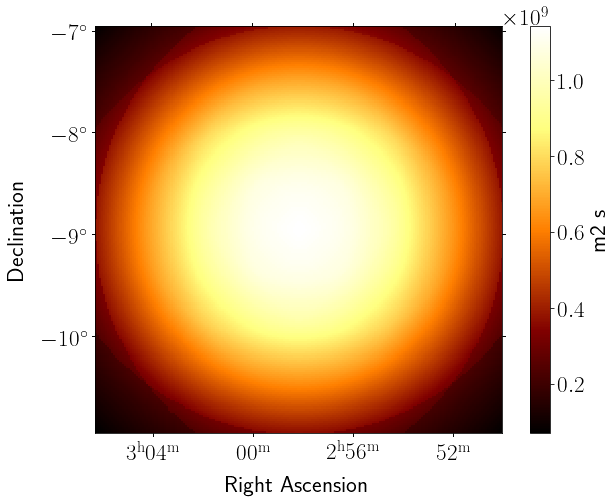

In [24]:
fig = plt.figure()
f_exp_on = stacked_on_off.exposure.sum_over_axes().plot(add_cbar = True)[0]
#save(fig, '2D-On-exposure-map_High_level')

## b) Off exposure map

- To get the off exposure maps we multiplied the On exposure map and the off acceptance known as system acceptance of gamma-ray like events. 
- This again will depend on the effective area and the livetime.

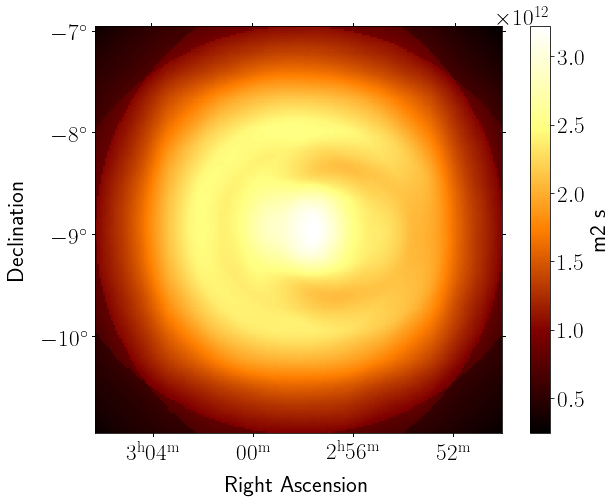

In [25]:
exp_off = stacked_on_off.exposure.sum_over_axes()*stacked_on_off.acceptance_off.sum_over_axes()
f_exp_off = exp_off.sum_over_axes().plot(add_cbar = True)[0]
#save(fig, '2D-off-exposure-map_High_level')

## c) On-counts Map
- we also check the On counts Map

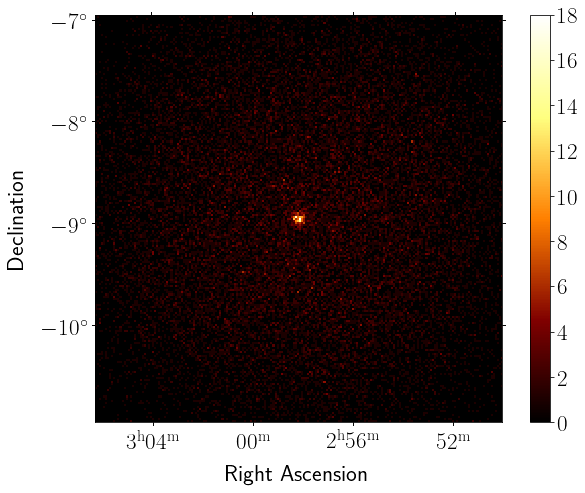

In [26]:
fig,ax,_ = stacked_on_off.counts.sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-On-counts_maps_High_level')

## d) Off-counts Map

- Off counts Map is also explored here.

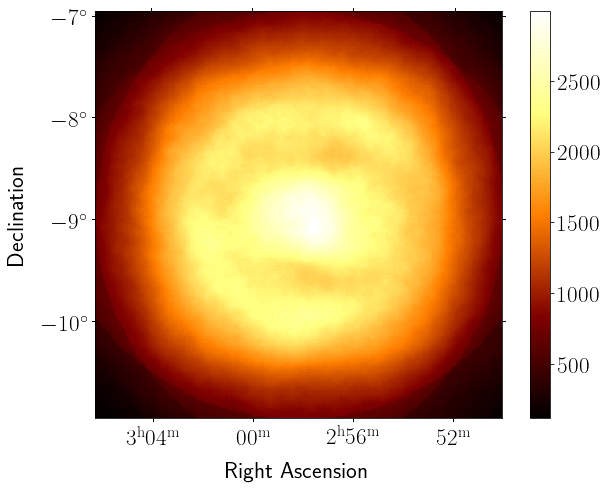

In [27]:
fig, ax,_ = stacked_on_off.counts_off.sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-off-counts-maps_High_level')

# Estimating Li & Ma maps.

## Compute correlated significance and correlated excess maps.

- We need to convolve our maps with an apprpriate smoothing kernel. 
- The significance is computed according to the Li & Ma expression for ON and OFF Poisson measurements, see here. 
- Since astropy convolution kernels only accept integers, we first convert our required size in degrees to int depending on our pixel size.

- It turned out that the Li&Ma solution is equivalent to the case with Cash or WStat statistics (with one analysis bin) under the assumption of Wilk’s theorem.
- So without writing the explicit Li&Ma formula, one get’s the equivalent result, with a Likelihood ratio test, assuming that the “best fit” value for the predicted counts is given by the excess. 
- This is implemented in the CountsStatistic classes see [here](https://docs.gammapy.org/0.18.2/api/gammapy.stats.CashCountsStatistic.html#gammapy.stats.CashCountsStatistic) (with know background) or [here](https://docs.gammapy.org/0.18.2/api/gammapy.stats.WStatCountsStatistic.html#gammapy.stats.WStatCountsStatistic) (Classical On/Off case).

In [28]:
%%time
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.05 * u.deg, )
lima_maps = estimator.run(stacked_on_off, steps=["ts",'err','errn-errp','ul']) # steps = 'all'

CPU times: user 4min 49s, sys: 22.2 s, total: 5min 11s
Wall time: 5min 12s


# Plotting all possible maps and Distribution!

## e. Cliped Excess map [clipped at zero]

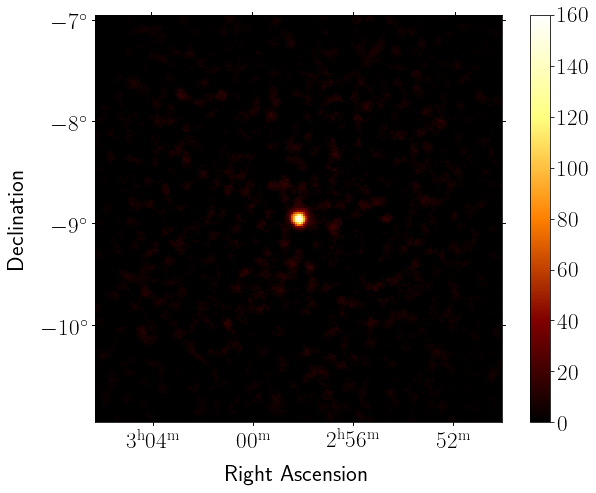

In [29]:
map_excess_clipped = lima_maps['excess'].copy()
map_excess_clipped.data = map_excess_clipped.data.clip(min = 0)
fig, ax,_ = map_excess_clipped.sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-excess-map_High_level')

## f. Excess map with source excluded.

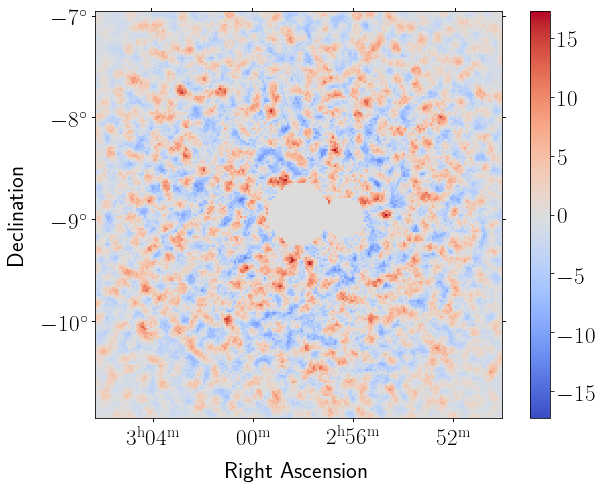

In [30]:
map_excess_excl = lima_maps['excess'].copy()
map_excess_excl.data[:] *= exclusion_mask.data[0]
maxentry = np.abs(map_excess_excl.data).max()
fig,ax,_ = map_excess_excl.sum_over_axes().plot(
    add_cbar = True, cmap='coolwarm', vmin = -maxentry, vmax=maxentry
                                               )
#save(fig, '2D-excess_withexclusion_High_level')

## g) Background-Map

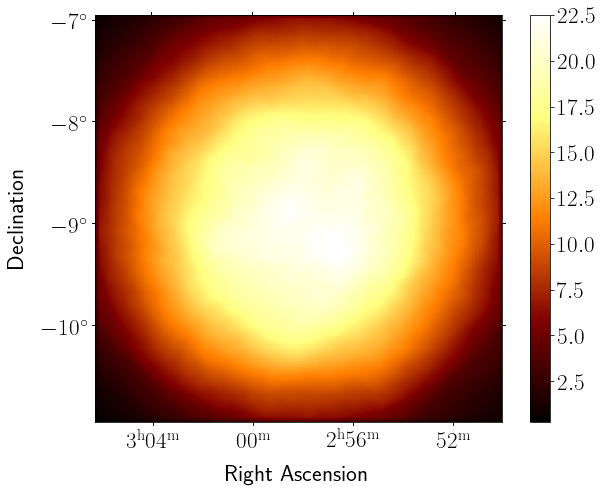

In [31]:
fig,ax,_ = lima_maps['background'].sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-background-map_High_level')

## h) Symmetric error map

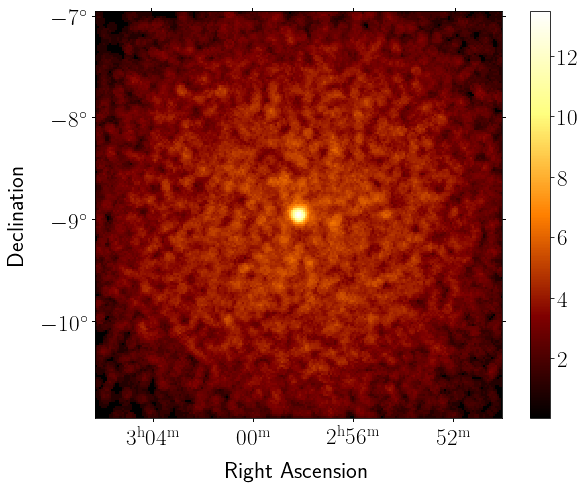

In [32]:
fig,ax,_ = lima_maps['err'].sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-symetric_error-map_High_level')

## i) Negative Asymmetric error Map 

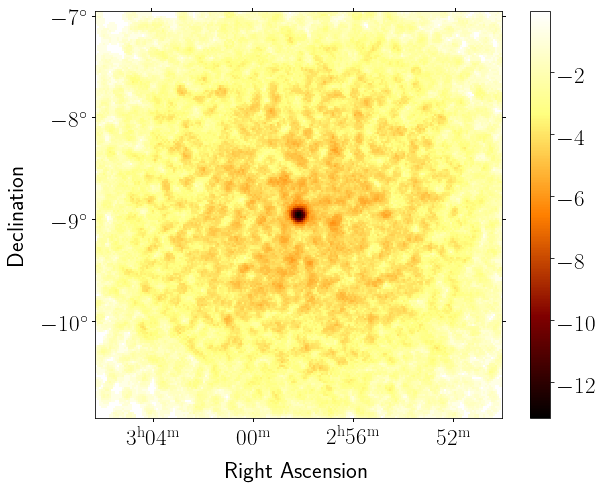

In [33]:
fig,ax,_ = lima_maps['errn'].sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-negative_asymmetric_error-map_High_level')

## j) Positive asymmetric error

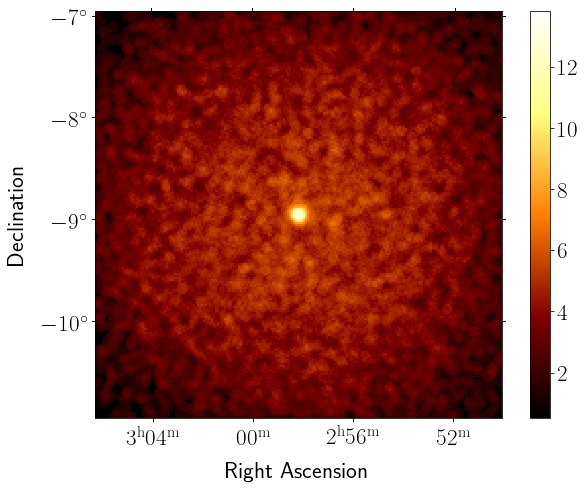

In [34]:
fig,ax,_ = lima_maps['errp'].sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-positive_asymmetric_error-map_High_level')

## k) Upper limit Map

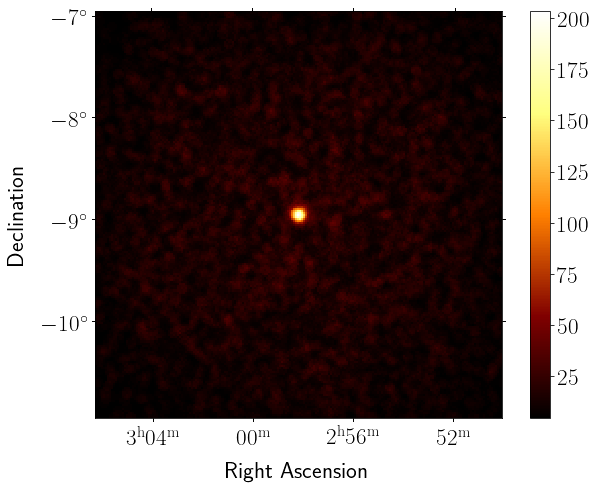

In [35]:
fig,ax,_ = lima_maps['ul'].sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-upperlimit-map_High_level')

## l) Test Statistics Map

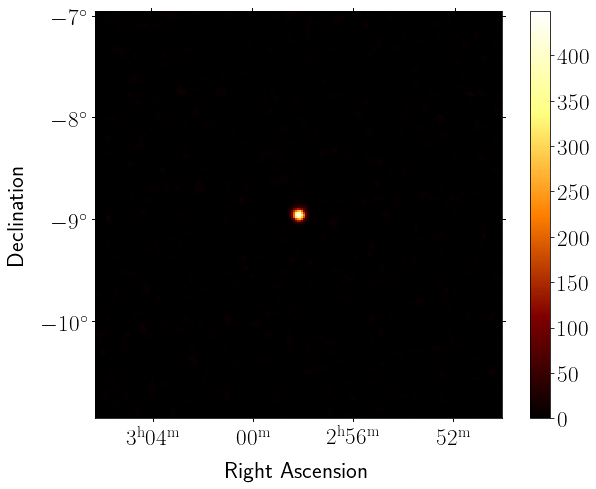

In [36]:
fig,ax,_ = lima_maps['ts'].sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-TS-map_High_level')

## m) Significance map

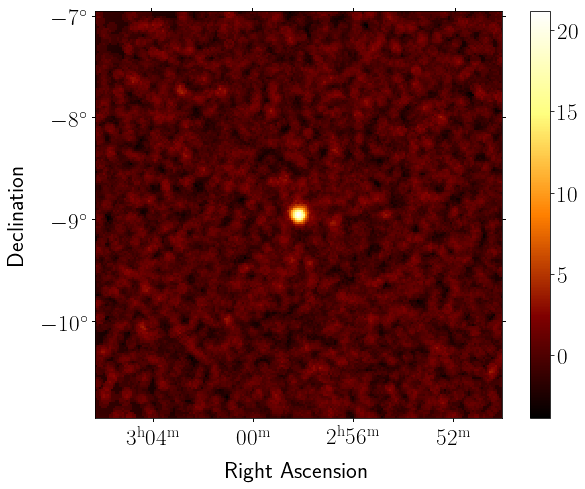

In [37]:
map_sign_clipped = lima_maps['significance'].copy()
#map_sign_clipped.data = map_sign_clipped.data.clip(min=0) # do not clip
fig,ax,_ = map_sign_clipped.sum_over_axes().plot(add_cbar = True)
#save(fig, '2D-significance-map_High_level')

## n) Significance map with source excluded

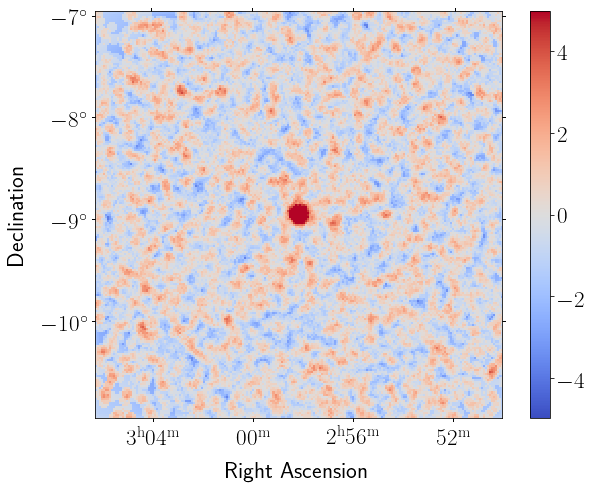

In [38]:
map_sign_excl = lima_maps['significance'].copy()

# map_sign_excl.data *= mask.data[0]

fig,ax,cb = map_sign_excl.sum_over_axes().plot(
    add_cbar = True, cmap = 'coolwarm', vmin=-5, vmax=5, 
                                              )
#save(fig, '2D-significance-map_with_exclusion_High_level')

## o) Significance distribution 

### (include only pixels within 2.25 deg radius)

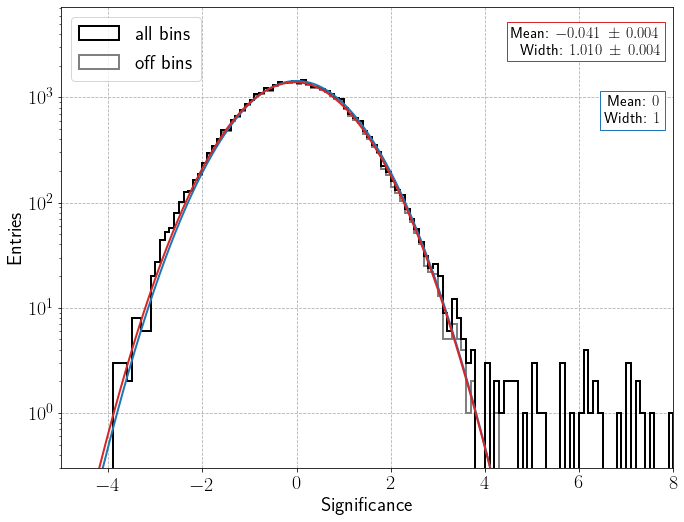

In [41]:
sdbins = np.linspace (-5, 8,131)
def get_binc(bins):
    bin_center = (bins[:-1] + bins[1:]) / 2
    return bin_center
reg_inner = CircleSkyRegion(source_pos, 2.25 * u.deg)
inner = geom.region_mask([reg_inner], inside=True)[0]

sign_inner = lima_maps['significance'].sum_over_axes().data[inner]

sign_excl = map_sign_excl.sum_over_axes().data.copy()
sign_excl[~exclusion_mask.data[0].astype(bool)] = -999.
sign_excl_inner = sign_excl[inner]
sign_inner[np.isnan(sign_excl_inner)] = -999.
sign_excl_inner[np.isnan(sign_excl_inner)] = -999.

fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0.12, 0.12, 0.85, 0.8])
ax.grid(ls='--')
ax.set_yscale('log')
ax.set_xlabel('Significance', fontsize =20)
ax.set_ylabel('Entries', fontsize =20)
h = ax.hist(sign_inner, bins=sdbins, histtype='step', color='k', lw=2, zorder=5, label = 'all bins')[0]
h = ax.hist(sign_excl_inner, bins=sdbins, histtype='step', color='gray', lw=2, zorder=3, label = 'off bins')[0]

gaus = lambda x,amp,mean,sigma:amp*np.exp(-(x-mean)**2/2/sigma**2)
xv = np.linspace(sdbins[0], sdbins[-1], 1000)
res = scipy.optimize.curve_fit(gaus, get_binc(sdbins), h, p0=[h.max(), 0., 1.])
pars = res[0]
errs = np.sqrt(np.diag(res[1]))
ax.plot(xv, gaus(xv, pars[0], pars[1], pars[2]), color='tab:red', lw=2, zorder=7)

ax.text(0.98, 0.96, 'Mean: ${:.3f}\,\pm\,{:.3f}$\nWidth: ${:.3f}\,\pm\,{:.3f}$'.format(pars[1],errs[1], pars[2], errs[2]),
        ha='right', va='top', bbox=dict(edgecolor='tab:red', facecolor='white'), transform=ax.transAxes, fontsize=16)

ax.plot(xv, gaus(xv, h.max(), 0, 1), color='tab:blue', lw=2, zorder=6)

ax.text(0.98, 0.81, 'Mean: $0$\nWidth: $1$', ha='right', va='top',fontsize=16,
        bbox=dict(edgecolor='tab:blue', facecolor='white'), transform=ax.transAxes)

ax.set_xlim(sdbins[0], sdbins[-1])
ax.set_ylim(bottom=0.3)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(loc = 'upper left',fontsize=20);
# format_log_axis(ax.yaxis)
#save(fig, '1D_significance_distribution_High_level')

## p) Theta^2 Distribution plot.

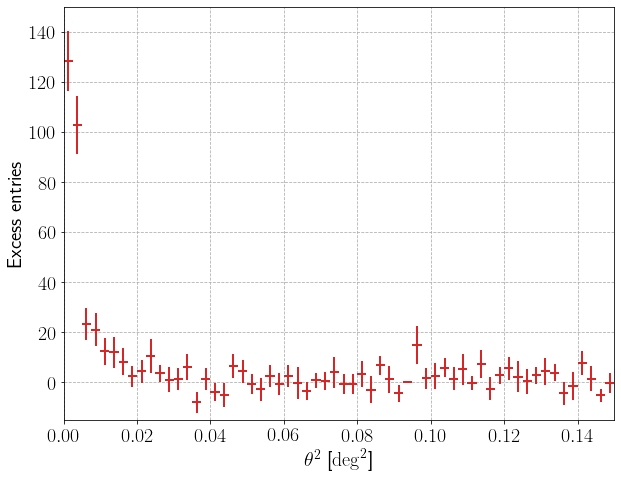

In [42]:
# Theta^2 plot
tsbins = np.linspace(0, 0.3, 121)
excess_noconv = stacked_on_off.excess
excess_noconv_err = np.sqrt(stacked_on_off.counts.sum_over_axes().data +\
                            stacked_on_off.alpha.data**2 * stacked_on_off.counts_off.sum_over_axes().data)
thsq = stacked_on_off.counts.geom.get_coord().skycoord.separation(source_pos).value**2
thsq_excess = np.histogram(thsq, bins=tsbins, weights=excess_noconv)[0]
thsq_excess_err = np.sqrt(np.histogram(thsq, bins=tsbins, weights=excess_noconv_err**2)[0])

tsbinc = get_binc(tsbins)
xerr = [tsbinc - tsbins[:-1], tsbins[1:] - tsbinc]

# create figure
fig = plt.figure(figsize=(9, 7))
ax = fig.add_axes([0.12, 0.15, 0.85, 0.82])
ax.grid(ls='--')
ax.set_xlabel(r'$\theta^2$ [$\mathrm{deg}^2$]', fontsize = 20)
ax.set_ylabel('Excess entries', fontsize = 20)

# plot distributions
pexc = ax.errorbar(tsbinc, thsq_excess, xerr=xerr, yerr=thsq_excess_err, linestyle='None',
                   ecolor='tab:red', capsize=0, elinewidth=2)

# set axis limits
ax.set_xlim(tsbins[0], 0.15)
ax.set_ylim(-15, 150)
ax.tick_params(axis='both', which='major', labelsize=20)
#save(fig, '1D-thetasquare_distribution_High_level')

## r) Total significance 
### Distribution Histogram in the whole FoV

- It is often important to look at the signficance distribution outside the exclusion region to check that the background estimation is not contaminated by gamma-ray events. 
- This can be the case when exclusion regions are not large enough. 
- Typically, we expect the off distribution to be a standard normal distribution.

Fit results: mu = -0.06, std = 1.01


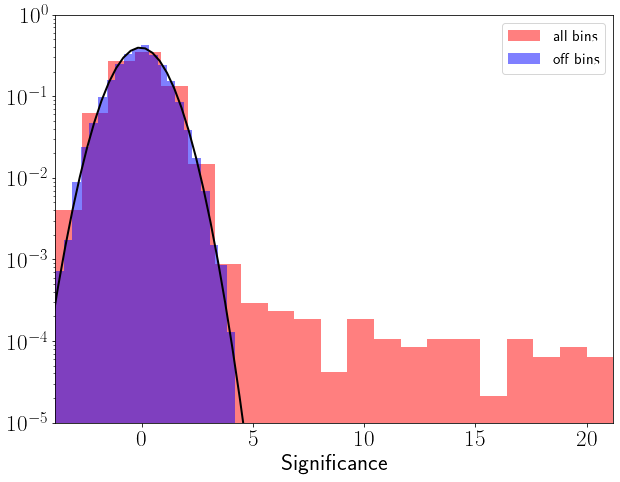

In [43]:
# create a 2D mask for the images
significance_map_off = lima_maps['significance'] * exclusion_mask
significance_all = lima_maps['significance'].data[np.isfinite(lima_maps['significance'].data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)
#save(fig, 'Total_significance_distribution_high_level')
print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")

* Note *: Finally we are done with the first Night 2D map analysis.